In [1]:
!git clone https://github.com/benmola/AI4AD-ADM1-Workshop..git
%cd AI4AD-ADM1-Workshop.

!pip install -r requirements.txt

from ADM1 import ADM1Simulator
import matplotlib.pyplot as plt
from matplotlib.animation import FuncAnimation
import pandas as pd
from ipywidgets import interact, FloatSlider, Button, VBox, HBox, Output, Accordion
from IPython.display import display, FileLink, clear_output
from tqdm import tqdm
import os

Cloning into 'AI4AD-ADM1-Workshop.'...
remote: Enumerating objects: 54, done.
remote: Counting objects: 100% (54/54), done.
remote: Compressing objects: 100% (52/52), done.
remote: Total 54 (delta 26), reused 0 (delta 0), pack-reused 0 (from 0)
Receiving objects: 100% (54/54), 29.47 KiB | 538.00 KiB/s, done.
Resolving deltas: 100% (26/26), done.
/content/AI4AD-ADM1-Workshop.
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.6/1.6 MB 16.8 MB/s eta 0:00:00


In [2]:
def get_feedstock_ratios(maize_silage, grass_silage, food_waste, cattle_slurry):
    ratios = {
        'Maize Silage': maize_silage,
        'Grass Silage': grass_silage,
        'Food Waste': food_waste,
        'Cattle Slurry': cattle_slurry
    }
    total = sum(ratios.values())
    if total == 0:
        return ratios  # Avoid division by zero
    normalized = {k: v / total for k, v in ratios.items()}
    if abs(sum(normalized.values()) - 1) > 0.01:
        print('⚠️ Warning: Normalized ratios do not sum to exactly 1 (possible rounding issue).')
    return normalized

In [5]:
def run_adm1(maize_silage, grass_silage, food_waste, cattle_slurry, HRT, V, Q, T, output):
    with output:
        clear_output(wait=True)
        ratios = get_feedstock_ratios(maize_silage, grass_silage, food_waste, cattle_slurry)
        days = int(HRT)
        simulator = ADM1Simulator(ratios, days=days, Q=Q, V=V, T=T)

        # Simulate with progress bar
        print('ADM1 Simulation in Progress....')
        with tqdm(total=days, desc='Simulating Days') as pbar:
            simulator.run()  # Assuming run() is not iterable; if it is, yield and update pbar
            pbar.update(days)  # If run() is quick, this fakes progress; modify if run() loops

        output_data = simulator.get_results()
        if output_data.empty:
            print('❌ Simulation returned no data.')
            return

        # Patch for compatibility
        if 'V' not in output_data.columns:
            output_data['V'] = V

        # Steady-state summary as styled table
        summary_data = {
            'Metric': ['pH', 'FOS', 'TAC', 'FOS/TAC', 'Methane Flow Rate', 'Biogas', 'Gas Pressure'],
            'Value': [
                output_data['pH'].iloc[-1],
                output_data['FOS'].iloc[-1],
                output_data['TAC'].iloc[-1],
                output_data['FOS/TAC'].iloc[-1],
                output_data['q_ch4'].iloc[-1],
                output_data['q_gas'].iloc[-1],
                output_data['p_gas'].iloc[-1]
            ]
        }
        summary_df = pd.DataFrame(summary_data)
        styled_summary = summary_df.style.background_gradient(cmap='viridis', subset=['Value']).set_caption('📊 Steady State Simulation Summary')
        display(styled_summary)

        # Animated plots
        fig, axs = plt.subplots(5, 1, figsize=(10, 12), sharex=True)
        fig.suptitle('ADM1 Simulation Time-Series Results')

        lines = []
        titles = ['Methane Flow Rate', 'Biogas Flow Rate', 'pH Over Time', 'FOS/TAC Ratio', 'Gas Pressure']
        columns = ['q_ch4', 'q_gas', 'pH', 'FOS/TAC', 'p_gas']
        ylabels = ['Methane (m³/d)', 'Biogas (m³/d)', 'pH', 'Ratio', 'Pressure']

        for i, (col, title, ylabel) in enumerate(zip(columns, titles, ylabels)):
            axs[i].set_title(title)
            axs[i].set_ylabel(ylabel)
            axs[i].grid(True)
            axs[i].set_xlim(0, output_data['time'].max())
            axs[i].set_ylim(0, output_data[col].max() * 1.1)
            line, = axs[i].plot([], [], lw=2)
            lines.append(line)
        axs[-1].set_xlabel('Time (days)')

        def init():
            for line in lines:
                line.set_data([], [])
            return lines

        def animate(frame):
            for i, line in enumerate(lines):
                line.set_data(output_data['time'][:frame], output_data[columns[i]][:frame])
            return lines

        ani = FuncAnimation(fig, animate, init_func=init, frames=len(output_data), interval=50, blit=True, repeat=False)
        plt.tight_layout()
        plt.show()

        # Export button
        export_button = Button(description='Export Results to CSV')
        def on_export_clicked(b):
            filename = 'ADM1_results.csv'
            output_data.to_csv(filename, index=False)
            display(FileLink(filename))
            print(f'✅ CSV exported: {filename}')
        export_button.on_click(on_export_clicked)
        display(export_button)

        print('Simulation Complete.')

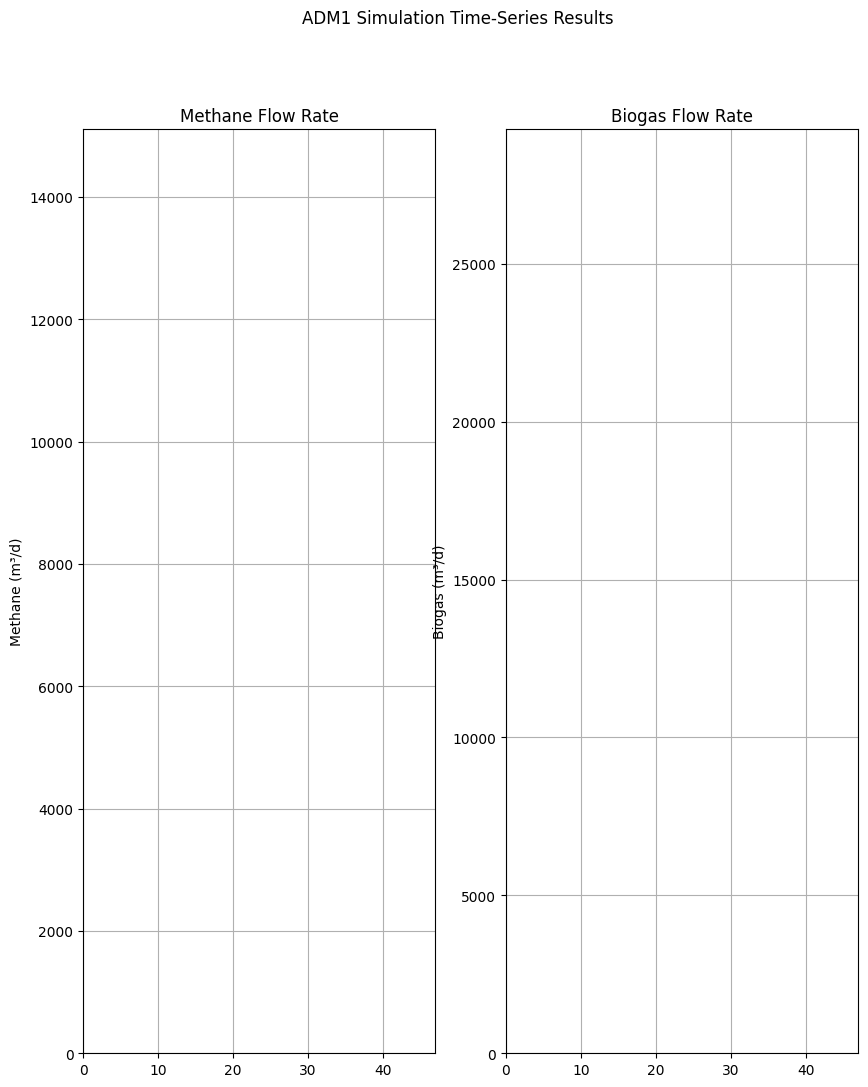

In [6]:
# Output widget
output = Output()

# Sliders
maize_slider = FloatSlider(min=0, max=1, step=0.1, value=0.5, description='Maize Silage')
grass_slider = FloatSlider(min=0, max=1, step=0.1, value=0.3, description='Grass Silage')
food_slider = FloatSlider(min=0, max=1, step=0.1, value=0.1, description='Food Waste')
cattle_slider = FloatSlider(min=0, max=1, step=0.1, value=0.1, description='Cattle Slurry')
hrt_slider = FloatSlider(min=10, max=80, step=2, value=48, description='HRT (days)')
v_slider = FloatSlider(min=1000, max=10000, step=500, value=6520, description='V (m³)')
q_slider = FloatSlider(min=50, max=500, step=10, value=136.63, description='Q (m³/d)')
t_slider = FloatSlider(min=15, max=60, step=1, value=45, description='T (°C)')

# Group into accordions for better UI
feedstock_acc = Accordion(children=[VBox([maize_slider, grass_slider, food_slider, cattle_slider])])
feedstock_acc.set_title(0, 'Feedstock Ratios')
process_acc = Accordion(children=[VBox([hrt_slider, v_slider, q_slider, t_slider])])
process_acc.set_title(0, 'Process Parameters')

# Buttons
run_button = Button(description='Run Simulation')
reset_button = Button(description='Reset Sliders')

def on_run_clicked(b):
    run_adm1(maize_slider.value, grass_slider.value, food_slider.value, cattle_slider.value,
             hrt_slider.value, v_slider.value, q_slider.value, t_slider.value, output)

def on_reset_clicked(b):
    maize_slider.value = 0.5
    grass_slider.value = 0.3
    food_slider.value = 0.1
    cattle_slider.value = 0.1
    hrt_slider.value = 48
    v_slider.value = 6520
    q_slider.value = 136.63
    t_slider.value = 45
    with output:
        clear_output(wait=True)
        print('Sliders reset to defaults.')

run_button.on_click(on_run_clicked)
reset_button.on_click(on_reset_clicked)

# Display interface
display(VBox([HBox([feedstock_acc, process_acc]), HBox([run_button, reset_button]), output]))